In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

In [11]:
def entropy_func(class_count, num_samples):
    entropy = 0
    for class_val in class_count:
        p = class_count[class_val] / num_samples
        entropy -= p * math.log2(p)

    return entropy

class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return self.group_classes.size

    def group_entropy(self):
        class_count = Counter(self.group_classes)
        return entropy_func(class_count, len(self.group_classes))


class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.child_node_a is None and self.child_node_b is None:
            return self.val

        if data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        total_samples = len(group_a) + len(group_b)
        split_entropy = (len(group_a) / total_samples) * group_a.entropy + (len(group_b) / total_samples) * group_b.entropy
        return split_entropy

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        return parent_group.entropy - self.get_split_entropy(child_group_a, child_group_b)

    def get_best_split(self, data, classes):
        feature_values = np.array(data)
        best_feature, best_val = None, None
        best_info_gain = -1

        for feature in range(feature_values.shape[1]):  # Iterate over features
            for val in np.unique(feature_values[:, feature]):  # Iterate over unique values
                # Split data based on current feature and value
                mask_a = feature_values[:, feature] <= val
                mask_b = feature_values[:, feature] > val

                group_a = Group(classes[mask_a])
                group_b = Group(classes[mask_b])

                # Calculate information gain
                info_gain = self.get_information_gain(Group(classes), group_a, group_b)

                # Update the best split if information gain is higher
                if info_gain > best_info_gain:
                    best_feature = feature
                    best_val = val
                    best_info_gain = info_gain

        return best_feature, best_val
    

    def _build_tree(self, data, classes, depth=0):
        if len(set(classes)) == 1 or depth >= self.max_depth:
            return Node(val=Counter(classes).most_common(1)[0][0])

        best_feature, best_val = self.get_best_split(data, classes)

        mask_a = data[:, best_feature] <= best_val
        mask_b = data[:, best_feature] > best_val

        child_node_a = self._build_tree(data[mask_a], classes[mask_a], depth + 1)
        child_node_b = self._build_tree(data[mask_b], classes[mask_b], depth + 1)

        return Node(best_feature, best_val, depth, child_node_a, child_node_b)
    
    def build_tree(self, data, classes):
        self.tree = self._build_tree(data, classes)
        return self.tree


    def predict(self, sample):
        if not self.tree:
            raise ValueError("The tree has not been built yet. Call build_tree() first.")
        return self.tree.predict(sample)

In [12]:
def test(depth=3, test_size=0.1, random_state=None, verbose=0):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.build_tree(x_train, y_train)
    predictions = [clf.predict(x) for x in x_test]
    for i in range(len(predictions)):
        if verbose is not None and i % verbose == 0:
            print(f"Prediction: {predictions[i]}, Actual: {y_test[i]}")
    accuracy = np.mean(predictions == y_test)
    if verbose is not None:
        print(f"Accuracy: {accuracy}")
    return accuracy

In [13]:
def test_depths(test_size=0.1, random_state=None, verbose=None, plot_range=10):
    x, y = [i for i in range(1, plot_range)], []
    for depth in range(1, plot_range):
        if verbose is not None:
            print(f"Depth: {depth}")
        sum_ac = 0
        for i in range(20):
            sum_ac += test(depth, test_size, random_state, verbose)
        sum_ac /= 20
        y.append(sum_ac)
    plt.plot(x, y)

    plt.xlabel("Depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Depth")
    plt.show()


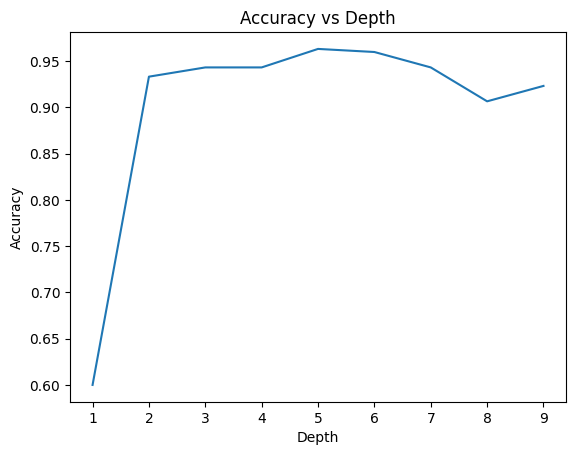

In [14]:
test_depths()

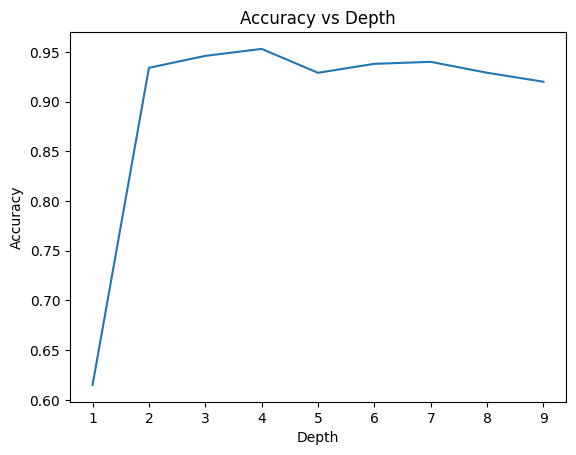

In [15]:
test_depths(test_size=50)

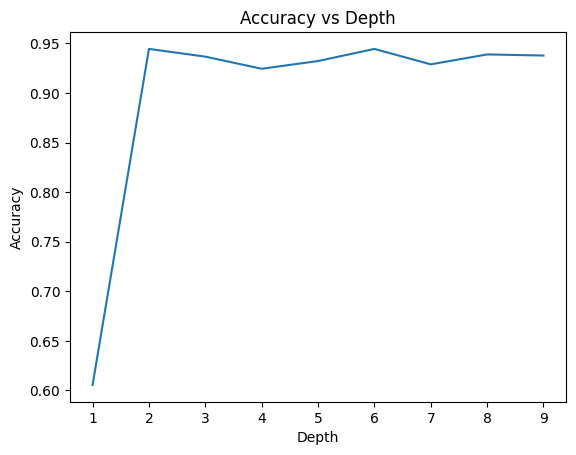

In [16]:
test_depths(test_size=0.3)

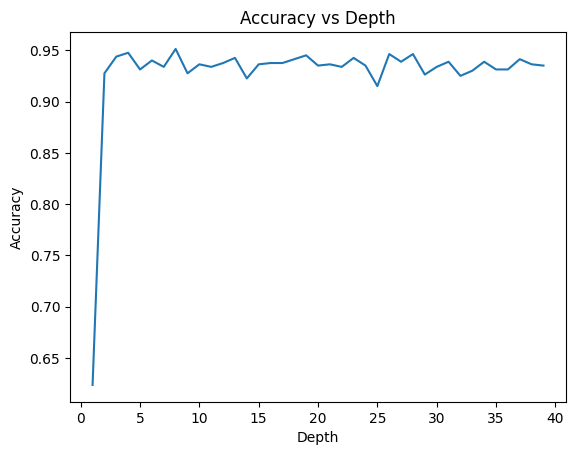

In [17]:
test_depths(test_size = 40, plot_range=40)

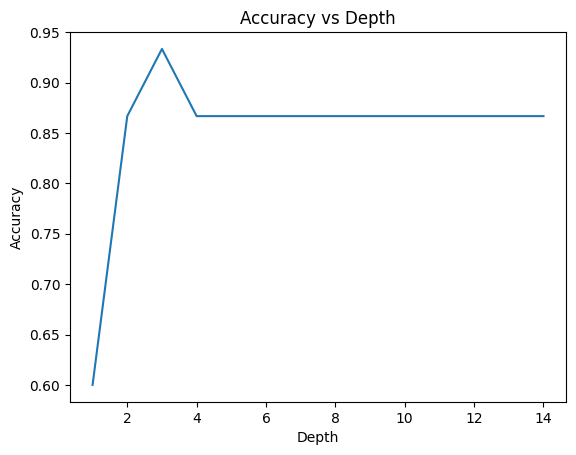

In [18]:
test_depths(test_size=0.1, random_state=123, plot_range=15)